In [45]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
import gymnasium as gym



class Direction(Enum):
    RIGHT = (0, 1)
    LEFT = (0, -1)
    UP = (-1, 0)
    DOWN = (1, 0)


class GridWorld:

    def __init__(self, position):
        self.position = position
        self.reward = 0
        state_dtype = np.dtype([('key', 'U2'), ('state_value', 'f4')])
        self.grid = np.array([[(None, 0) for _ in range(5)]
                             for _ in range(5)], dtype=state_dtype)
        self.grid[0, 1]['key'] = 'A'
        self.grid[0, 3]['key'] = 'B'
        self.grid[4, 1]['key'] = 'A_'
        self.grid[2, 3]['key'] = 'B_'

    def move(self, position, direction: Direction):
        new_position = tuple(sum(x) for x in zip(position, direction.value))
        if new_position[0] < 0 or new_position[1] < 0 or new_position[0] > 4 or new_position[1] > 4:
            return -1, position

        elif self.grid[new_position]['key'] == 'A':
            new_position = (4,1)
            return 10, new_position

        elif self.grid[new_position]['key'] == 'B':
            new_position = (2,3)
            return 10, new_position
        else:
            return 0, new_position

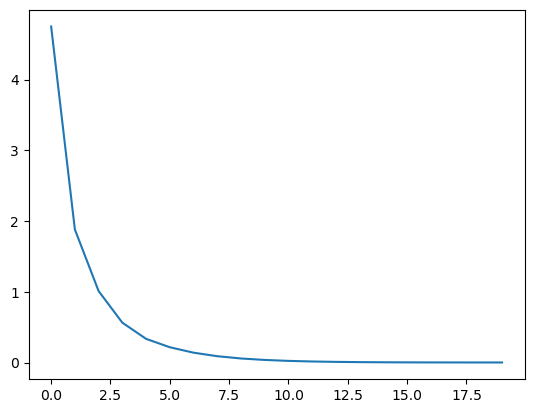

In [46]:
grid_world = GridWorld(np.random.randint(0, 5, size=2))
iterations = 20
discount = 0.9
diff_arr = []
for i in range(iterations):
    diff = 0
    for index, value in np.ndenumerate(grid_world.grid):
        new_value = 0
        for action in list(Direction):
            reward, next_state = grid_world.move(index, action)
            new_value += 1 / 4 * (reward + discount * grid_world.grid[next_state]['state_value'])
        temp_diff = abs(new_value - value['state_value'])
        if(temp_diff > diff):
            diff = temp_diff
        value['state_value'] = new_value
    diff_arr.append(diff)

plt.plot(diff_arr)
plt.show()

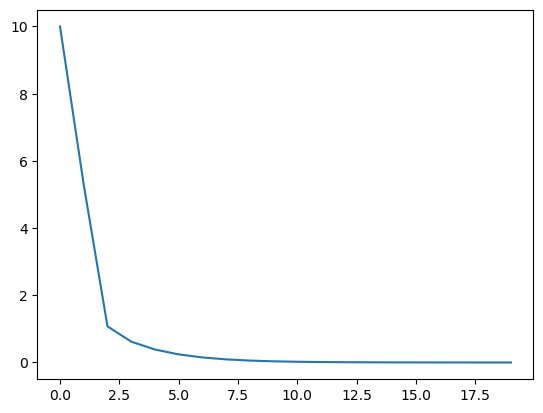

In [47]:
grid_world = GridWorld(np.random.randint(0, 5, size=2))
iterations = 20
discount = 0.9
action_value_arr = np.zeros((5, 5, 4))
diff_arr = []


def action_value(action, state_index, action_value_arr):
    new_value = 0
    reward, next_state = grid_world.move(state_index, action)
    for i in range(len(list(Direction))):
        action_value_arr_index = next_state + (i,)
        new_value += 1 / 4 * (action_value_arr[action_value_arr_index])
    return reward + discount * new_value


for i in range(iterations):
    diff = 0
    for index, value in np.ndenumerate(grid_world.grid):
        new_value = 0
        for j, action in enumerate(list(Direction)):
            new_value = action_value(action, index, action_value_arr)
            temp_diff = abs(new_value - action_value_arr[index +
                                                    (j,)])
            if(temp_diff > diff):
                diff = temp_diff
            action_value_arr[index +
                             (j,)] = new_value
    diff_arr.append(diff)
plt.plot(diff_arr)
plt.show()


In [42]:
class GridWorldGym(gym.Env):

    def __init__(self):
        super(GridWorldGym, self).__init__()
        self.action_space = gym.spaces.Discrete(4)
        """ 
        0 == UP
        1 == DOWN
        2 == LEFT
        3 == RIGHT 
        """
        self.observation_space = gym.spaces.Box(
            low=np.array([0, 0]), high=np.array([4, 4]), dtype=int)
        self.special_states = {
            'A': (0, 1),
            'B': (0, 3),
            'A_': (4, 1),
            'B_': (2, 3)
        }
        self.state = np.zeros((2), dtype=int)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Ruft die Basis-Reset-Funktion mit seed auf

        self.done = False
        self.state = np.zeros((2), dtype=int)
        return np.array(self.state), {}

    def step(self, action):
        done = False
        new_state = None
        reward = 0
        if action == 0:
            new_state = self.state + (-1, 0)
        elif action == 1:
            new_state = self.state + (1, 0)
        elif action == 2:
            new_state = self.state + (0, -1)
        elif action == 3:
            new_state = self.state + (0, 1)
        else:
            raise ValueError('Fehler')

        if new_state[0] < 0 or new_state[1] < 0 or new_state[0] > 4 or new_state[1] > 4:
            reward = -1
        elif tuple(new_state) == self.special_states["A"]:
            reward = 10
            self.state = new_state
            done = True
        elif tuple(new_state) == self.special_states["B"]:
            reward = 5
            self.state = new_state
            done = True

        else:
            self.state = new_state

        return self.state, reward, done, False, {}


gym.register("My_Grid_World", '__main__:GridWorldGym')


In [44]:
env = gym.make("My_Grid_World")

# Führe mehrere Schritte aus
obs, info = env.reset()  # Setze die Umgebung zurück
print(obs)
total_reward = 0    # Gesamtbelohnung initialisieren
done = False

while not done:
    action = env.action_space.sample()  # Wähle eine zufällige Aktion
    obs, reward, done, truncated, info = env.step(
        action)  # Führe die Aktion aus
    total_reward += reward  # Update die Gesamtbelohnung
    print(
        f"Aktion: {action}, Neue Beobachtung: {obs}, Belohnung: {reward}, Done: {done}")

print(f"Gesamtbelohnung nach der Episode: {total_reward}")

[0 0]
Aktion: 1, Neue Beobachtung: [1 0], Belohnung: 0, Done: False
Aktion: 3, Neue Beobachtung: [1 1], Belohnung: 0, Done: False
Aktion: 3, Neue Beobachtung: [1 2], Belohnung: 0, Done: False
Aktion: 1, Neue Beobachtung: [2 2], Belohnung: 0, Done: False
Aktion: 2, Neue Beobachtung: [2 1], Belohnung: 0, Done: False
Aktion: 3, Neue Beobachtung: [2 2], Belohnung: 0, Done: False
Aktion: 0, Neue Beobachtung: [1 2], Belohnung: 0, Done: False
Aktion: 2, Neue Beobachtung: [1 1], Belohnung: 0, Done: False
Aktion: 1, Neue Beobachtung: [2 1], Belohnung: 0, Done: False
Aktion: 0, Neue Beobachtung: [1 1], Belohnung: 0, Done: False
Aktion: 1, Neue Beobachtung: [2 1], Belohnung: 0, Done: False
Aktion: 2, Neue Beobachtung: [2 0], Belohnung: 0, Done: False
Aktion: 2, Neue Beobachtung: [2 0], Belohnung: -1, Done: False
Aktion: 3, Neue Beobachtung: [2 1], Belohnung: 0, Done: False
Aktion: 1, Neue Beobachtung: [3 1], Belohnung: 0, Done: False
Aktion: 1, Neue Beobachtung: [4 1], Belohnung: 0, Done: False
A